In [1]:
import numpy as np
from sklearn.decomposition import PCA 
import pandas as pd
from asyncio.windows_events import NULL
import catboost
from sklearn.metrics import precision_score,classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import random
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
import joblib
import matplotlib.pyplot as plt           #用 plot()函数绘制折线图    
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score

In [3]:
Tumor_file = pd.read_excel('dataset.xlsx')
dataset = Tumor_file.values

In [4]:
#choose first 10 features
#粒淋比，D二聚体，化疗，置管方式，胸部治疗，本院治疗年龄，血小板，血红蛋白，BMI
# print(Tumor_file.columns.tolist())
d1 = Tumor_file["置管方式"].values.copy()
d1-=1
tmp1 = Tumor_file["肺部放疗"].values.copy()
tmp2 = Tumor_file["纵隔放疗"].values.copy()
d2 = Tumor_file["胸部治疗"].values.copy()
for i in range(len(tmp2)):
    if tmp2[i] == 1 or tmp1[i] == 1:
        d2[i] = 1

tmp3 = Tumor_file["卵巢癌"].values.copy()
d3  = Tumor_file["宫颈癌"].values.copy()
for i in range(len(tmp3)):
    if tmp3[i] == 1:
        d3[i] = 1

tmp4 = Tumor_file["L肾癌"].values.copy()
tmp5 = Tumor_file["O肾上腺癌"].values.copy()
tmp6 = Tumor_file["M输尿管膀胱"].values.copy()
d4 = Tumor_file["K睾丸癌"].values.copy()
for i in range(len(tmp4)):
    if tmp4[i] == 1 or tmp5[i] == 1 or tmp6[i] == 1:
        d4[i] = 1

data = np.vstack((
    Tumor_file["粒细胞/淋巴细胞"].values.copy(),
    Tumor_file["D二聚体"].values.copy(),
    Tumor_file["化疗"].values.copy(),
    d1,
    d2,
    Tumor_file["本院治疗年龄"].values.copy(),
    Tumor_file["血小板"].values.copy(),
    Tumor_file["血红蛋白"].values.copy(),
    Tumor_file["BMI"].values.copy(),
    Tumor_file["性别"].values.copy(),
    Tumor_file["既往置管史"].values.copy(),
    Tumor_file["既往血栓史"].values.copy(),
    Tumor_file["肺癌"].values.copy(),
    Tumor_file["胃癌"].values.copy(),
    Tumor_file["淋巴瘤"].values.copy(),
    d3,
    d4
    )).T
variable_names = [
    "粒细胞/淋巴细胞",
    "D二聚体",
    "化疗",
    "置管方式",
    "胸部治疗",
    "本院治疗年龄",
    "血小板",
    "血红蛋白",
    "BMI",
    "性别",
    "既往置管史",
    "既往血栓史",
    "肺癌",
    "胃癌",
    "淋巴瘤",
    "妇科肿瘤",
    "泌尿系统肿瘤"
    ]

tumor = Tumor_file["血栓有1；无0"].values.copy()

dst = Tumor_file["置管日期"].values.copy()
ded = Tumor_file["拔管日期"].values.copy()
during = Tumor_file["血栓发生置管后天数"].values.copy()

for i in range(data.shape[0]):
    if type(dst[i]).__name__ == 'str':
        dst[i] = pd.to_datetime(dst[i])
    if type(ded[i]).__name__ == 'str':
        ded[i] = pd.to_datetime(ded[i])

print(data.shape)


(20667, 17)


In [5]:
have_built = 0
Tumor = []
Time = []
for i in range(data.shape[0]):
    flag = True
    for j in range(data.shape[1]):
        if (type(data[i,j]).__name__ != 'float' and type(data[i,j]).__name__ != 'int') or np.isnan(data[i,j]) or data[i,j]<0:
            flag = False
            break
    if np.isnan(tumor[i]):
        flag = False
    if data[i,3] >= 2:
        flag = False
    if flag:
        if tumor[i] == 0:
            Time.append((ded[i]-dst[i]).days)
        else:
            Time.append(during[i])
        if have_built == 0:
            Data = data[i]
            Data = np.reshape(Data,(1,-1))
        else:
            Data = np.vstack((Data,np.reshape(data[i],(1,-1))))
        Tumor.append(tumor[i])
        have_built += 1
print(have_built)

10512


In [5]:
KM_Data = Data.copy()
for i in range(KM_Data.shape[0]):
    KM_Data[i][0] = 0 if KM_Data[i][0] < 3.0 else 1
    KM_Data[i][1] = 0 if KM_Data[i][1] < 1.03 else 1
    KM_Data[i][6] = 0 if KM_Data[i][6] < 350 else 1
    KM_Data[i][7] = 0 if KM_Data[i][7] < 100 else 1
    KM_Data[i][8] = 0 if KM_Data[i][8] < 27 else 1
    KM_Data[i][5] = 0 if KM_Data[i][5] < 65 else 1
print(len(Tumor),KM_Data.shape)

10512 (10512, 9)


In [21]:
#因果推断
names = ['粒淋比','D二聚体','化疗','置管方式','胸部治疗','本院治疗年龄','血小板','血红蛋白','BMI']
list_index = [2,3,4]
causal_data = Data.copy()
causal_data[:,9]-=1
all_ates = []
for i in list_index:
    treatment = causal_data[:,i].astype(int)
    print(treatment[treatment==1].shape[0],treatment[treatment==0].shape[0])
    features = causal_data[:,[i for i in range(causal_data.shape[1]) if i not in list_index]]
    outcome = np.array(Tumor)

    regmodel = LogisticRegression(max_iter=10000)
    regmodel.fit(features,treatment)

    probx = regmodel.predict_proba(features)[:,1]
    y_ipw = outcome*(treatment-probx)/(probx*(1-probx))
    ate_ipw = np.sum(treatment/probx*outcome)/treatment[treatment==1].shape[0]-np.sum((1-treatment)/(1-probx)*outcome)/treatment[treatment==0].shape[0]
    ate_ipw1 = np.mean(y_ipw)
    print(names[i],ate_ipw1)
print(np.sum(Tumor))

IndexError: index 9 is out of bounds for axis 1 with size 9

In [258]:
mds = ['RandomForest','Catboost','LogisticRegression','AdaBoost','XGBoost','BalancedRandomForest','Khorana']
ROC_AUCs = []
PR_AUCs = []
Sensitivities = []
Specificities = []
Accuracies = []
Precisions = []
Fprs = []
Tprs = []

In [7]:
for i in range(Data.shape[1]):
    if len(set(Data[:,i])) == 2:
        print(set(Data[:,i]))

{0, 1}
{0, 1}
{0.0, 1.0}
{1, 2}
{0, 1}
{0, 1}
{0, 1}
{0, 1}
{0, 1}
{0, 1}
{0, 1}


In [9]:
SEED = 42
np.random.seed(SEED)
Data_df = Data.copy()
Tumor_df = Tumor.copy()
X_train,X_test,y_train,y_test=train_test_split(Data_df,Tumor_df,test_size=0.2,random_state=SEED)

#过采样数据
smote = SMOTE(random_state=SEED)
adasyn = ADASYN(random_state=SEED)
X_se,y_se = smote.fit_resample(Data_df,Tumor_df)
# X_se,y_se = adasyn.fit_resample(Data_df,Tumor_df)

for j in range(X_se.shape[1]):
    if len(set(Data[:,j])) == 2:
        for i in range(X_se.shape[0]):
            X_se[i,j] = 0 if X_se[i,j] <0.5 else 1

X_train_se,X_test_se,y_train_se,y_test_se=train_test_split(X_se,y_se,test_size=0.2,random_state=SEED)

print(set(Data_df[:,2]),set(Data_df[:,3]),set(Data_df[:,4]))
print(set(X_train_se[:,2]),set(X_train_se[:,3]),set(X_train_se[:,4]))

#基学习器训练集和测试集
X_train_base,X_test_base,y_train_base,y_test_base=train_test_split(X_train_se,y_train_se,test_size=0.5,random_state=SEED)

print(X_train_base.shape,X_test.shape,X_train.shape)

{0, 1} {0, 1} {0.0, 1.0}
{0.0, 1.0} {0.0, 1.0} {0.0, 1.0}
(7598, 17) (2103, 17) (8409, 17)


In [10]:
from sklearn.base import clone

def get_models():
    brf = BalancedRandomForestClassifier(n_estimators=1000,max_depth = 7,random_state=SEED,sampling_strategy='all',replacement=True,bootstrap=False)
    ctb = CatBoostClassifier(learning_rate=0.001,max_depth=7,verbose=0,random_state=SEED)
    lr = LogisticRegression(max_iter=10000)
    ada = AdaBoostClassifier(n_estimators=1000,learning_rate=0.001,random_state=SEED)
    xgb = XGBClassifier(n_estimators=1000,learning_rate=0.001)

    models = {
        'Balanced Random Forest': brf,
        'Catboost': ctb,
        'Logistic Regression': lr,
        'AdaBoost': ada,
        'XGBoost': xgb
    }
    return models

def train_base_model(model_list,inp,label,verbose=False):
    for i,(name,m) in enumerate(model_list.items()):
        # 训练用SMOTE过采样的数据
        if verbose:print(f"Training {name}...")
        m.fit(inp,label)
        if verbose:print(f"finish training {name}")
    if verbose:print("Done")

def predict_base_model(model_list,inp):
    probs = np.zeros((inp.shape[0],len(model_list)))
    for i,(name,m) in enumerate(model_list.items()):
        # 预测用原始数据
        probs[:,i] = m.predict_proba(inp)[:,1]
    
    return probs

def stacking(base_learners,meta_learner,X,y,generator):
    y = np.array(y)
    # 训练总的基学习器
    train_base_model(base_learners,X,y)
    
    # 进行交叉验证
    cv_preds, cv_y = [], []
    for i,(train_idx,test_idx) in enumerate(generator.split(X)):
        
        fold_xtrain,fold_ytrain = X[train_idx,:],y[train_idx]
        fold_xtest,fold_ytest = X[test_idx,:],y[test_idx]

        # 训练fold的基学习器
        fold_base_learners = {name:clone(model) for name,model in base_learners.items()}
        train_base_model(fold_base_learners,fold_xtrain,fold_ytrain)

        # 获取元学习器的训练数据
        fold_probs = predict_base_model(fold_base_learners,fold_xtest)
        cv_preds.append(fold_probs)
        cv_y.append(fold_ytest)
    
    # 训练元学习器
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)
    print(cv_preds.shape,cv_y.shape)

    meta_learner.fit(cv_preds,cv_y)

    return base_learners,meta_learner

In [12]:
from sklearn.model_selection import KFold

base_models = get_models()
meta_model = GradientBoostingClassifier(
    n_estimators=1000,
    learning_rate=0.005,
    max_features=4,
    subsample=0.5,
    max_depth=7,
    random_state=SEED
)

#训练基学习器
train_base_model(base_models,inp=X_train_base,label=y_train_base)

#训练元学习器
probs = predict_base_model(base_models,inp=X_test_base)
print(probs.shape)
meta_model.fit(probs,y_test_base)

#测试元学习器
base_probs = predict_base_model(base_models,inp=X_test_se)
meta_probs = meta_model.predict_proba(base_probs)[:,1]

# cv_base_learners,cv_meta_learners = stacking(base_models,clone(meta_model),X_train_se,y_train_se,KFold(n_splits=5))
# base_probs = predict_base_model(cv_base_learners,X_test)
# meta_probs = cv_meta_learners.predict_proba(base_probs)[:,1]
print('gradient ensemble',roc_auc_score(y_test_se,meta_probs))

(7598, 5)
gradient ensemble 0.855553837782366


In [333]:
base_probs = predict_base_model(base_models,inp=Data)
meta_probs = meta_model.predict_proba(base_probs)[:,1]
for i in meta_probs:
    print(i)

0.038910595545593965
0.46885273106809355
0.16825162064056767
0.7730102136517014
0.4335722092923105
0.4532463629925166
0.6946995147362751
0.2511824075687994
0.485736297299164
0.5333454225935091
0.10701971534914075
0.13058365162964897
0.588329713474556
0.5979743492383115
0.0736419277662935
0.13059400445663086
0.26452833006664683
0.3045154479899338
0.201557577631487
0.6815603665653229
0.03405673249462547
0.06765457020515105
0.10769373902392267
0.03706471757663616
0.13483390206861068
0.5853496799406942
0.36300916013296175
0.5830804707619079
0.617696552826237
0.06260165380306774
0.08469035284720779
0.3503522986869485
0.16755469707564905
0.09818439041337793
0.29509044346430907
0.6959133994517304
0.06876158647706639
0.11653220835409327
0.08609691266842438
0.08073302271452282
0.22927615459022693
0.5708971215155065
0.078947616736437
0.29095198397410443
0.7792146693225807
0.03273377685975944
0.04873380169235203
0.2050626917496259
0.059643644181534075
0.1265071375337234
0.17402092045867137
0.1458

Balanced Random Forest 0.7933920590116044
Val accuracy	0.7060526315789474
Precision: 0.738801261829653
Recall: 0.6248665955176094
Specificity: 0.7850467289719626
Catboost 0.755083777460821
Val accuracy	0.6676315789473685
Precision: 0.696969696969697
Recall: 0.5768409818569904
Specificity: 0.7559709241952233
Logistic Regression 0.681040549421443
Val accuracy	0.6276315789473684
Precision: 0.6327356853672643
Recall: 0.583778014941302
Specificity: 0.670301142263759
AdaBoost 0.6789559485377318
Val accuracy	0.6444736842105263
Precision: 0.6611213801601972
Recall: 0.572572038420491
Specificity: 0.7144340602284528
XGBoost 0.7699739618831669
Val accuracy	0.6915789473684211
Precision: 0.7052631578947368
Recall: 0.6435432230522946
Specificity: 0.7383177570093458
Average Ensemble 0.7622601905509175
gradient ensemble 0.8599687919399864
Val accuracy	0.7794736842105263
Precision: 0.7732067510548524
Recall: 0.7822838847385272
Specificity: 0.7767393561786086


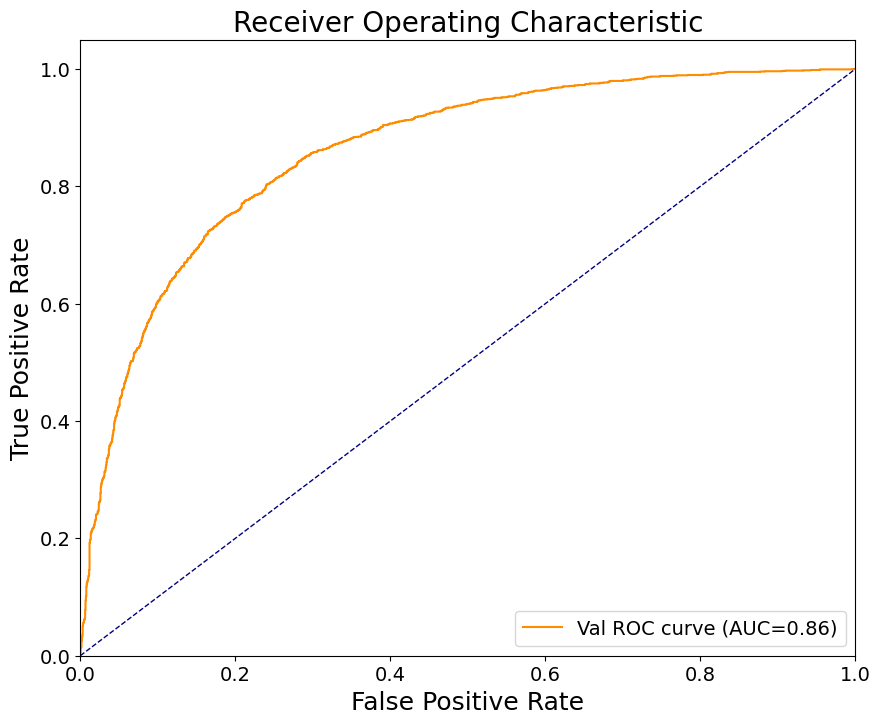

In [16]:

Fprs = []
Tprs = []
ROC_AUCs = []
model_names = list(base_models.keys())
for m in range(base_probs.shape[1]):
    fpr,tpr,_ = roc_curve(y_test_se,base_probs[:,m])
    Fprs.append(fpr)
    Tprs.append(tpr)
    ROC_AUCs.append(auc(fpr,tpr))
    score = roc_auc_score(y_test_se,base_probs[:,m])
    print(model_names[m],score)

    y_predict = base_models[model_names[m]].predict(X_test_se)
    tn,fp,fn,tp = confusion_matrix(y_test_se,y_predict).ravel()
    print("Val accuracy\t"+str(np.mean(y_test_se == y_predict)))
    print("Precision:",precision_score(y_test_se, y_predict))
    print("Recall:",tp/(tp+fn))
    print("Specificity:",tn/(tn+fp))

print('Average Ensemble',roc_auc_score(y_test_se,base_probs.mean(axis=1)))
print('gradient ensemble',roc_auc_score(y_test_se,meta_probs))
y_predict = meta_model.predict(base_probs)
tn,fp,fn,tp = confusion_matrix(y_test_se,y_predict).ravel()
print("Val accuracy\t"+str(np.mean(y_test_se == y_predict)))
print("Precision:",precision_score(y_test_se, y_predict))
print("Recall:",tp/(tp+fn))
print("Specificity:",tn/(tn+fp))

fpr,tpr, thresholds = roc_curve(y_test_se,meta_probs)
roc_auc = auc(fpr,tpr)
Fprs.append(fpr)
Tprs.append(tpr)
ROC_AUCs.append(auc(fpr,tpr))



plt1,ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr,color='darkorange',label='Val ROC curve (AUC={:.2f})'.format(roc_auc))
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xticks(np.arange(0.0,1.1,0.2))
ax.set_yticks(np.arange(0.0,1.1,0.2))
ax.set_xticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'],fontsize=14,weight='light')
ax.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'],fontsize=14,weight='light')
ax.set_xlabel('False Positive Rate',fontsize=18)
ax.set_ylabel('True Positive Rate',fontsize=18)
ax.set_title('Receiver Operating Characteristic',fontsize=20)
ax.legend(loc="lower right",prop={'size': 14, 'weight':'light'},labelspacing=0.8)
plt.show()

In [70]:
def accuracy_validate(clf,X,y,mode):
    y_predict=clf.predict(X)
    from sklearn import metrics
    #print(metrics.classification_report(y, y_predict))
    tn, fp, fn, tp = confusion_matrix(y, y_predict).ravel()
    if mode == 0 :
        print("Train accurary\t"+str(np.mean(y == y_predict)))
        print("Precision:",precision_score(y, y_predict))
        print("Recall:",tp/(tp+fn))
        print("Specificity:",tn/(tn+fp))
        print("-"*50)
    else:
        print("Val accuracy\t"+str(np.mean(y == y_predict)))
        print("Precision:",precision_score(y, y_predict))
        print("Recall:",tp/(tp+fn))
        print("Specificity:",tn/(tn+fp))
        # Sensitivities.append('%.4f'%(tp/(tp+fn)))
        # Specificities.append('%.4f'%(tn/(tn+fp)))
        # Accuracies.append('%.4f'%(np.mean(y == y_predict)))
        # Precisions.append('%.4f'%(precision_score(y, y_predict)))
        print("-"*50)



seed = 55
test_size=0.2
#cat_features = [0,3,4,6,7,9,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,45]

X_train,X_test,y_train,y_test=train_test_split(Data,Tumor,test_size=test_size,random_state=seed)

'''pca = PCA(n_components=25)# of the features
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)'''

smote = SMOTE(random_state=42)
X_se,y_se = smote.fit_resample(Data,Tumor)
X_train_se,X_test_se,y_train_se,y_test_se = train_test_split(X_se,y_se,test_size=test_size,random_state=seed)


# model = RandomForestClassifier(max_depth=7,n_estimators=100,random_state=42)
model = CatBoostClassifier(depth=7,learning_rate=0.01,verbose=False)
# model = LogisticRegression(max_iter=10000)
# model = AdaBoostClassifier(learning_rate=0.02,random_state=1)
# model = XGBClassifier(n_estimators=100,max_depth = 7, learning_rate = 0.01,subsample = 0.75,gamma = 1,min_child_weight = 7,)
#model=GridSearchCV(estimator=estimator,param_grid=params,scoring='roc_auc',cv=3)
#model = LassoCV(cv=5,random_state=1)
# model = BalancedRandomForestClassifier(n_estimators=100,max_depth = 7)
model.fit(X_train_se, y_train_se)

accuracy_validate(model,X_train,y_train,0)
accuracy_validate(model,X_test,y_test,1)


fpr,tpr, thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])
fpr_2,tpr_2, thresholds_2 = roc_curve(y_train,model.predict_proba(X_train)[:,1])
precision,recall,_ = precision_recall_curve(y_test,model.predict_proba(X_test)[:,1])

# Fprs.append(fpr)
# Tprs.append(tpr)

roc_auc = auc(fpr,tpr)
roc_auc_2 = auc(fpr_2,tpr_2)
pr_auc = auc(recall,precision)
print('Train ROC_AUC:{}, Val ROC_AUC:{}, Val PR_AUC:{}'.format(roc_auc_2,roc_auc,pr_auc))

# ROC_AUCs.append('%.4f'%roc_auc)
# PR_AUCs.append('%.4f'%pr_auc)



Train accurary	0.9071233202521108
Precision: 0.5625
Recall: 0.2605548854041013
Specificity: 0.9778364116094986
--------------------------------------------------
Val accuracy	0.910603899191631
Precision: 0.4819277108433735
Recall: 0.21621621621621623
Specificity: 0.9775808133472367
--------------------------------------------------
Train ROC_AUC:0.8137075059438368, Val ROC_AUC:0.7940281261449145, Val PR_AUC:0.33687629215399817


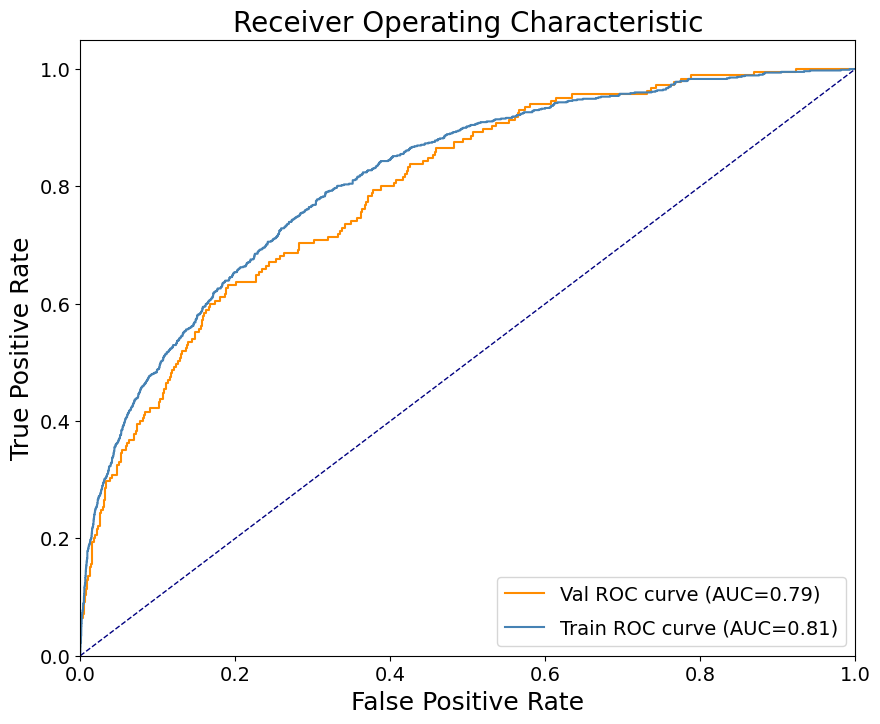

In [93]:

plt1,ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr,color='darkorange',label='Val ROC curve (AUC={:.2f})'.format(roc_auc))
ax.plot(fpr_2,tpr_2,color = 'steelblue',label='Train ROC curve (AUC={:.2f})'.format(roc_auc_2))
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xticks(np.arange(0.0,1.1,0.2))
ax.set_yticks(np.arange(0.0,1.1,0.2))
ax.set_xticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'],fontsize=14,weight='light')
ax.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'],fontsize=14,weight='light')
ax.set_xlabel('False Positive Rate',fontsize=18)
ax.set_ylabel('True Positive Rate',fontsize=18)
ax.set_title('Receiver Operating Characteristic',fontsize=20)
ax.legend(loc="lower right",prop={'size': 14, 'weight':'light'},labelspacing=0.8)
plt.show()


In [10]:
all_base_probs = predict_base_model(base_models,inp=Data)
all_prob = meta_model.predict_proba(all_base_probs)[:,1]
df = pd.DataFrame({'time':Time,'event':Tumor})
for i in range(KM_Data.shape[1]):
    df[f'Variable{i+1}'] = KM_Data[:,i].astype(np.int32)
high_risk = df[all_prob>=0.6]
mid_risk = df[(all_prob>=0.3) & (all_prob<0.6)]
low_risk = df[all_prob<0.3]
print(high_risk)

       time  event  Variable1  Variable2  Variable3  Variable4  Variable5  \
3        50      0          0          0          1          1          0   
6        15      0          0          0          1          0          0   
19       36      0          1          0          1          1          0   
28      154      0          1          0          1          1          0   
35      125      0          1          1          1          1          0   
...     ...    ...        ...        ...        ...        ...        ...   
10452    42      0          0          0          0          0          0   
10485    17      0          0          1          0          0          0   
10488    25      1          1          0          0          1          0   
10496    21      0          0          0          0          0          0   
10499    37      0          1          1          0          0          0   

       Variable6  Variable7  Variable8  Variable9  
3              0       

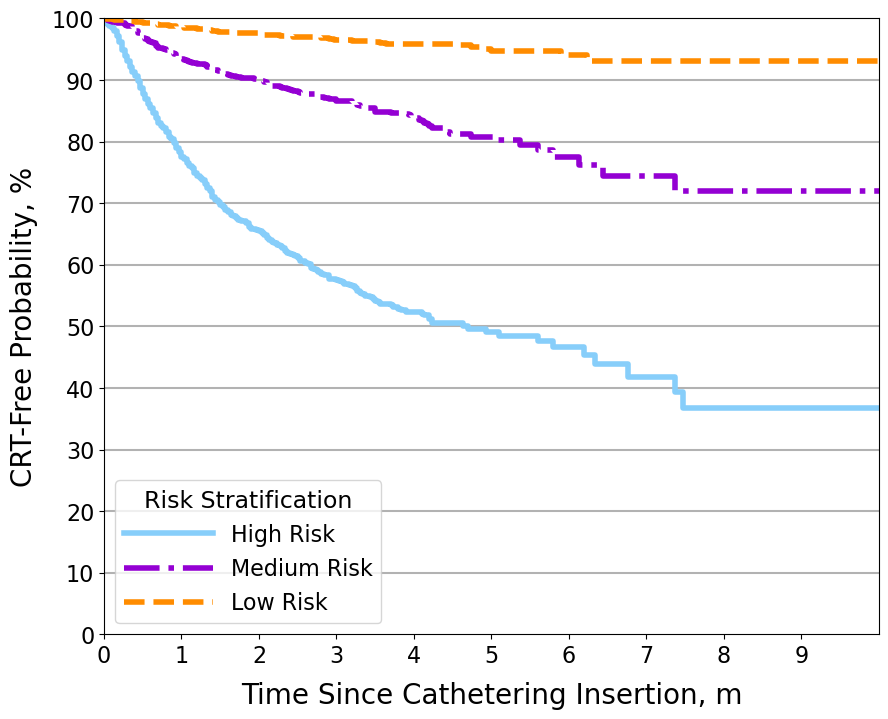

In [11]:
from lifelines import CoxPHFitter, KaplanMeierFitter

plt.rc('font',family='sans-serif')

plt1,ax = plt.subplots(figsize=(10,8))
kmf_high = KaplanMeierFitter(label='High Risk')
kmf_mid = KaplanMeierFitter(label='Medium Risk')
kmf_low = KaplanMeierFitter(label='Low Risk')

kmf_high.fit(high_risk.time,high_risk.event)
kmf_mid.fit(mid_risk.time,mid_risk.event)
kmf_low.fit(low_risk.time,low_risk.event)

ax.set_xlim(0,300)
ax.set_ylim(0.25,1)
ax.set_xticks(range(0,300,30))
ax.set_xticklabels(['0','1','2','3','4','5','6','7','8','9'],fontsize=16,weight='light')
ax.set_yticks(np.arange(0.0,1.01,0.1))
ax.set_yticklabels(['0','10','20','30','40','50','60','70','80','90','100'],fontsize=16,weight='light')

ax.axhline(y=0.9, color='black', alpha=0.3)
ax.axhline(y=0.8, color='black', alpha=0.3)
ax.axhline(y=0.7, color='black', alpha=0.3)
ax.axhline(y=0.6, color='black', alpha=0.3)
ax.axhline(y=0.5, color='black', alpha=0.3)
ax.axhline(y=0.4, color='black', alpha=0.3)
ax.axhline(y=0.3, color='black', alpha=0.3)
ax.axhline(y=0.2, color='black', alpha=0.3)
ax.axhline(y=0.1, color='black', alpha=0.3)

kmf_high.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='lightskyblue',linewidth=4,linestyle='-')
kmf_mid.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='darkviolet',linewidth=4,linestyle='-.')
kmf_low.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='darkorange',linewidth=4,linestyle='--')

legend = ax.legend(loc='lower left',prop={'size': 16,'weight':'light'},handlelength=4)
legend.set_title('Risk Stratification',prop={'size':17,'weight':'light'})
ax.set_ylabel('CRT-Free Probability, %',fontsize=20,labelpad=10)
ax.set_xlabel('Time Since Cathetering Insertion, m',fontsize=20,labelpad=10)

plt.show()

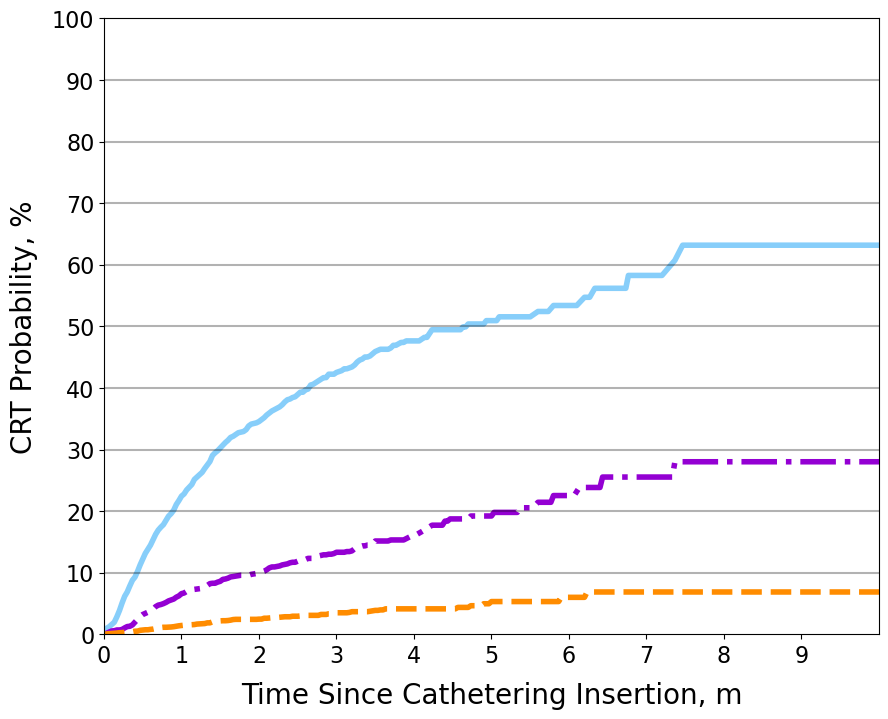

In [12]:
plt1,ax = plt.subplots(figsize=(10,8))
kmf_high_anti = 1-kmf_high.survival_function_
kmf_mid_anti = 1-kmf_mid.survival_function_
kmf_low_anti = 1-kmf_low.survival_function_

ax.plot(kmf_high_anti.index,kmf_high_anti.values, color='lightskyblue',linewidth=4,linestyle='-',label='High Risk')
ax.plot(kmf_mid_anti.index,kmf_mid_anti.values, color='darkviolet',linewidth=4,linestyle='-.',label='Medium Risk')
ax.plot(kmf_low_anti.index,kmf_low_anti.values, color='darkorange',linewidth=4,linestyle='--',label='Low Risk')

ax.set_xlim(0,300)
ax.set_ylim(0.25,1)
ax.set_xticks(range(0,300,30))
ax.set_xticklabels(['0','1','2','3','4','5','6','7','8','9'],fontsize=16,weight='light')
ax.set_yticks(np.arange(0.0,1.01,0.1))
ax.set_yticklabels(['0','10','20','30','40','50','60','70','80','90','100'],fontsize=16,weight='light')

ax.axhline(y=0.9, color='black', alpha=0.3)
ax.axhline(y=0.8, color='black', alpha=0.3)
ax.axhline(y=0.7, color='black', alpha=0.3)
ax.axhline(y=0.6, color='black', alpha=0.3)
ax.axhline(y=0.5, color='black', alpha=0.3)
ax.axhline(y=0.4, color='black', alpha=0.3)
ax.axhline(y=0.3, color='black', alpha=0.3)
ax.axhline(y=0.2, color='black', alpha=0.3)
ax.axhline(y=0.1, color='black', alpha=0.3)

# legend = ax.legend(loc='upper left',prop={'size': 16,'weight':'light'},handlelength=4)
# legend.set_title('Risk Stratification',prop={'size':17,'weight':'light'})
ax.set_ylabel('CRT Probability, %',fontsize=20,labelpad=10)
ax.set_xlabel('Time Since Cathetering Insertion, m',fontsize=20,labelpad=10)

plt.show()

In [15]:
from lifelines.statistics import logrank_test

results = logrank_test(mid_risk.time,low_risk.time,mid_risk.event,low_risk.event)
print(results.p_value)

4.3713440855097e-52


In [306]:
for i,(name,mdl) in enumerate(base_models.items()):
    joblib.dump(mdl, f"base_model{i}.pkl")
joblib.dump(meta_model, "meta_model.pkl")

['meta_model.pkl']

In [335]:
import sklearn
import imblearn
meta_mdl = joblib.load("meta_model.pkl")
base_mdl0 = joblib.load("base_model0.pkl")
base_mdl1 = joblib.load("base_model1.pkl")
base_mdl2 = joblib.load("base_model2.pkl")
base_mdl3 = joblib.load("base_model3.pkl")
base_mdl4 = joblib.load("base_model4.pkl")
base_mdl = {
    'Balanced Random Forest': base_mdl0,
    'Catboost': base_mdl1,
    'Logistic Regression': base_mdl2,
    'AdaBoost': base_mdl3,
    'XGBoost': base_mdl4
}
inputX = np.array(list(Data[12,:]))
inputX = np.reshape(inputX,(1,-1))
probs = np.zeros((inputX.shape[0],len(base_mdl)))
for i,(name,m) in enumerate(base_mdl.items()):
    probs[:,i] = m.predict_proba(inputX)[:,1]
meta_p = meta_mdl.predict_proba(probs)[0,1]
print(meta_p)

0.588329713474556


In [259]:
d1 = Tumor_file["胃癌"].values
d2 = Tumor_file["肺癌"].values
d3 = Tumor_file["淋巴瘤"].values
d4 = Tumor_file["宫颈癌"].values
d5 = Tumor_file["卵巢癌"].values
d6 = Tumor_file["K睾丸癌"].values
d7 = Tumor_file["M输尿管膀胱"].values
d8 = Tumor_file["7阴道"].values
d9 = Tumor_file["血小板"].values
d10 = Tumor_file["血红蛋白"].values
d11 = Tumor_file["白细胞"].values
d12 = Tumor_file["BMI"].values
kh_data = np.vstack((d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12)).T

In [260]:
have_built = 0
Kh_Tumor = []
for i in range(kh_data.shape[0]):
    flag = True
    for j in range(kh_data.shape[1]):
        if np.isnan(kh_data[i,j]) or kh_data[i,j]<0:
            # print(i,j,kh_data[i,j],type(kh_data[i,j]).__name__)
            flag = False
            break
    if np.isnan(tumor[i]):
        flag = False
    if flag:
        # print(kh_data[i])
        if have_built == 0:
            kh_Data = kh_data[i]
            kh_Data = np.reshape(kh_Data,(1,-1))
        else:
            kh_Data = np.vstack((kh_Data,np.reshape(kh_data[i],(1,-1))))
        Kh_Tumor.append(tumor[i])
        have_built += 1
print(have_built)

10811


In [261]:
print(len(Kh_Tumor),kh_Data.shape)

10811 (10811, 12)


Khorana ROC_AUC:0.5049973871282596,FPR:[0.00000000e+00 5.11875512e-04 8.08763309e-03 3.96191646e-02
 1.76392301e-01 5.70331695e-01 1.00000000e+00],TPR:[0.         0.         0.00575264 0.02876318 0.17929051 0.58293384
 1.        ]


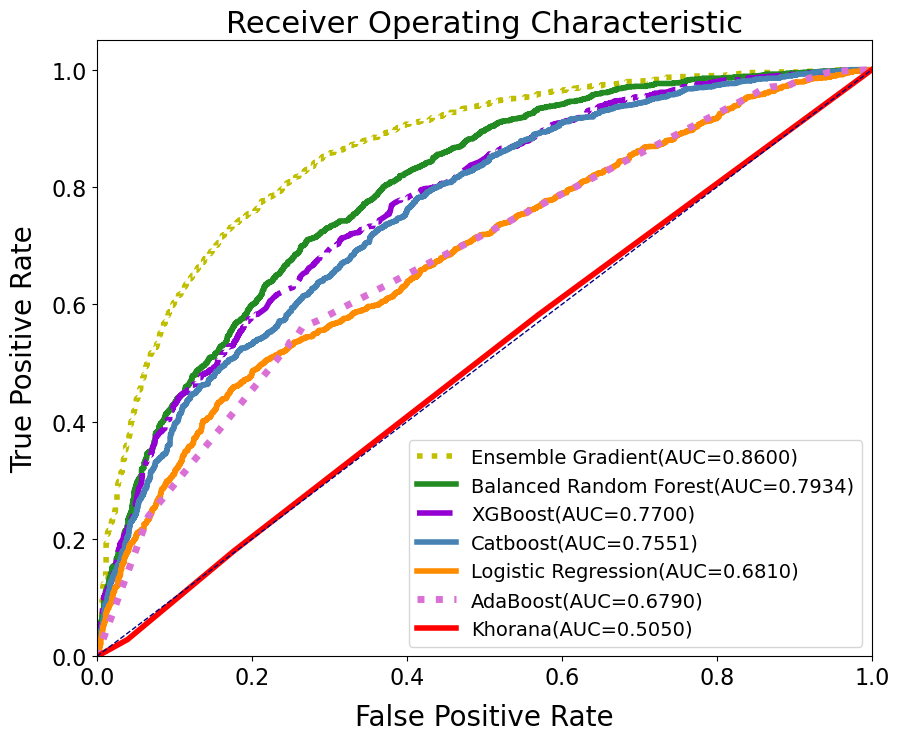

In [286]:
Kh_scores = []
for i in range(kh_Data.shape[0]):
    score = 0
    if kh_Data[i,0] == 1:
        score += 2
    if np.any(kh_Data[i,1:8]==1):
        score += 1
    if kh_Data[i,8] >= 350:
        score += 1
    if kh_Data[i,9] < 100:
        score += 1
    if kh_Data[i,10] > 11:
        score += 1
    if kh_Data[i,11] >= 35:
        score += 1
    Kh_scores.append(score)
# for i in range(Data.shape[0]):
#     score = 0
#     if Data[i][0] > 3.0:
#         score += 1
#     if Data[i][1] > 1.03:
#         score += 1
#     if Data[i][6] > 350:
#         score += 1
#     if Data[i][7] < 100:
#         score += 1
#     if Data[i][8] > 27:
#         score += 1
#     score += Data[i][2]+Data[i][3]+Data[i][4]
#     if Data[i][3] == 0:
#         score += 0.5
#     if Data[i][5]>41 and Data[i][5]<60:
#         score += 0.5
#     elif Data[i][5]>=60 and Data[i][5]<75:
#         score += 1
#     elif Data[i][5]>=75:
#         score += 1.5
#     Kh_scores.append(score)

fpr_kh,tpr_kh,_ = roc_curve(Kh_Tumor,Kh_scores)
roc_auc_kh = auc(fpr_kh,tpr_kh)
# ROC_AUCs.append('%.4f'%roc_auc_kh)
precision,recall,_ = precision_recall_curve(Kh_Tumor,Kh_scores)
pr_auc = auc(recall,precision)
# PR_AUCs.append('%.4f'%pr_auc)

tumor_pred = Kh_Tumor.copy()
for i in range(len(Kh_Tumor)):
    tumor_pred[i] = 1 if Kh_scores[i] >= 0.5 else 0
tn, fp, fn, tp = confusion_matrix(Kh_Tumor, tumor_pred).ravel()

# Sensitivities.append('%.4f'%(tp/(tp+fn)))
# Specificities.append('%.4f'%(tn/(tn+fp)))
# Accuracies.append('%.4f'%(np.mean(Kh_Tumor == tumor_pred)))
# Precisions.append('%.4f'%(precision_score(Kh_Tumor, tumor_pred)))
Fprs.append(fpr_kh)
Tprs.append(tpr_kh)
ROC_AUCs.append(roc_auc_kh)

print('Khorana ROC_AUC:{},FPR:{},TPR:{}'.format(roc_auc_kh,fpr_kh,tpr_kh))

plt.figure(figsize=(10,8))
plt.plot(Fprs[5],Tprs[5],lw=4,color='y',linestyle=':',label='Ensemble Gradient(AUC={:.4f})'.format(ROC_AUCs[5]))
plt.plot(Fprs[0],Tprs[0],lw=4,color='forestgreen',linestyle='-',label='{}(AUC={:.4f})'.format(model_names[0],ROC_AUCs[0]))
plt.plot(Fprs[4],Tprs[4],lw=4,color='darkviolet',linestyle='-.',label='{}(AUC={:.4f})'.format(model_names[4],ROC_AUCs[4]))
plt.plot(Fprs[1],Tprs[1],lw=4,color='steelblue',linestyle='-',label='{}(AUC={:.4f})'.format(model_names[1],ROC_AUCs[1]))
plt.plot(Fprs[2],Tprs[2],lw=4,color='darkorange',linestyle='-',label='{}(AUC={:.4f})'.format(model_names[2],ROC_AUCs[2]))
plt.plot(Fprs[3],Tprs[3],lw=5,color='orchid',linestyle=':',label='{}(AUC={:.4f})'.format(model_names[3],ROC_AUCs[3]))
plt.plot(Fprs[6],Tprs[6],lw=4,color='red',label='Khorana(AUC={:.4f})'.format(ROC_AUCs[6]))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16,weight='light')
plt.yticks(fontsize=16,weight='light')
plt.xlabel('False Positive Rate',fontsize=20,labelpad=10)
plt.ylabel('True Positive Rate',fontsize=20,labelpad=10)
plt.title('Receiver Operating Characteristic',fontsize=22)
plt.legend(loc="lower right",prop={'size': 14,'weight':'light'})
plt.show()

In [283]:
print(type(ROC_AUCs[0]))

<class 'str'>


In [277]:
df_model = pd.DataFrame({'model':mds,'roc_auc':ROC_AUCs,'pr_auc':PR_AUCs,'sensitivity':Sensitivities,'specificity':Specificities,'accuracy':Accuracies,'precision':Precisions})
df_model.to_excel('D:/Lab/Tumor/model_performance.xlsx',sheet_name='models',index=False)

In [115]:
print(np.random.uniform(0,1)+0.1)

0.13749981220550836


In [80]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_train_se, y_train_se, n_repeats=10,random_state=42)
print(result.importances_mean)

[6.37583893e-03 9.75786288e-03 1.17778655e-02 1.20278984e-02
 1.84234768e-03 8.02737202e-04 4.55981050e-03 1.05178313e-01
 3.63863666e-03 5.48032636e-02 3.37018029e-02 8.75115147e-04
 4.01368601e-04 1.90814581e-04 1.14488749e-03 1.15146730e-03
 4.80326359e-04 7.30359258e-04 6.47453612e-03 9.67890512e-03
 9.68548493e-03 1.24950651e-02 1.28437952e-02 1.04158442e-02
 9.25779708e-03 9.98815634e-03 8.61955520e-03 1.05540203e-02
 1.00736939e-02 1.03697855e-02 2.56744308e-02 3.46098171e-03
 6.57981313e-05 1.31596263e-03 2.63192525e-04 4.21108041e-04
 6.77720753e-04 9.21173839e-04 8.61955520e-04 1.64495328e-03
 2.31609422e-03]


In [19]:
import matplotlib

# features_imp = result.importances_mean
features_imp = model.feature_importances_
Name = Tumor_file.columns
names = ['粒淋比','D二聚体','化疗','置管方式','胸部治疗','本院治疗年龄','血小板','血红蛋白','BMI','性别']
Features_imp = []
Names = []

idx = np.argsort(np.array(features_imp))
for i in range(len(features_imp)):
        #if features_imp[idx[i]] > 0.0001:
        Names.append(names[idx[i]])
        Features_imp.append(features_imp[idx[i]])

Sum = np.array(Features_imp).sum()
for i in range(len(Features_imp)):
    Features_imp[i] = Features_imp[i]/Sum

matplotlib.rc('font', family='SimHei', weight='bold')
plt.rcParams['axes.unicode_minus'] = False

fig,ax = plt.subplots(figsize=(15,10))

ax.axvline(x=0.1,color="black",alpha=0.3) 
ax.axvline(x=0.2,color="black",alpha=0.3)
ax.axvline(x=0.3,color="black",alpha=0.3)
ax.axvline(x=0.4,color="black",alpha=0.3)
ax.axvline(x=0.5,color="black",alpha=0.3)


b = ax.barh(range(len(Names)),Features_imp,color='#6699CC',zorder=2)

for rect in b:
    w = rect.get_width()
    ax.text(w+0.0003,rect.get_y()+rect.get_height()/2,'%.4f'%w,ha='left',va='center')

ax.set_yticks(range(len(Names)))
ax.set_yticklabels(Names)
#ax.set_xticks()


plt.title('Features Importance',loc='center',fontsize='25',color='black',fontfamily='serif')


NameError: name 'model' is not defined

In [17]:
for i in range(len(names)):
    print(i,names[i])

0 粒淋比
1 D二聚体
2 化疗
3 置管方式
4 胸部治疗
5 本院治疗年龄
6 血小板
7 血红蛋白
8 BMI
9 性别


In [17]:
#问题：到底应该用什么数据求p值？可选的有Data,X_se,X_se_train,X_test,而feature_importance的数据是X_se_train。
#但目前来看更有可能不是p值的问题，是importance的问题
pdata0 = []
pdata1 = []
for i in range(X_train_se.shape[0]):
    if y_train_se[i]==1:
        pdata1.append(X_train_se[i])   
    else:
        pdata0.append(X_train_se[i])
pdata0 = np.array(pdata0)
pdata1 = np.array(pdata1)
print(pdata0.shape,pdata1.shape)

(7572, 9) (7624, 9)


In [31]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from statistics import stdev
P_values = []
stddevs = []

for i in range(Data.shape[1]):
    r,p = pearsonr(X_se[:,i],y_se)
    stddev = stdev(X_se[:,i])
    P_values.append(p)
    stddevs.append(stddev)
    print("Feature:{}, P-value:{}, stddev:{}".format(names[i],P_values[i],stddevs[i]))


Feature:粒淋比, P-value:2.3005698201426933e-11, stddev:3.836841519815378
Feature:D二聚体, P-value:0.07009747847360415, stddev:2.952074945437983
Feature:化疗, P-value:2.915323926121482e-12, stddev:0.4013780059238867
Feature:置管方式, P-value:1.76518962725e-312, stddev:0.4968658524737773
Feature:胸部治疗, P-value:2.0980188027827395e-136, stddev:0.4310613245532022
Feature:本院治疗年龄, P-value:9.079048845130852e-45, stddev:10.935048258427408
Feature:血小板, P-value:0.047765696958924755, stddev:89.97877850950897
Feature:血红蛋白, P-value:1.0717594712824994e-46, stddev:17.55082208332778
Feature:BMI, P-value:1.098052547200543e-09, stddev:3.4576353040314434


In [202]:
df1 = pd.DataFrame({'Feature':Names[::-1],'Importance':Features_imp[::-1],'P-value':P_values[::-1],'Stdev':stddevs[::-1]})
df1.to_excel('D:/Lab/Tumor/results.xlsx',sheet_name='特征重要度',index=False)

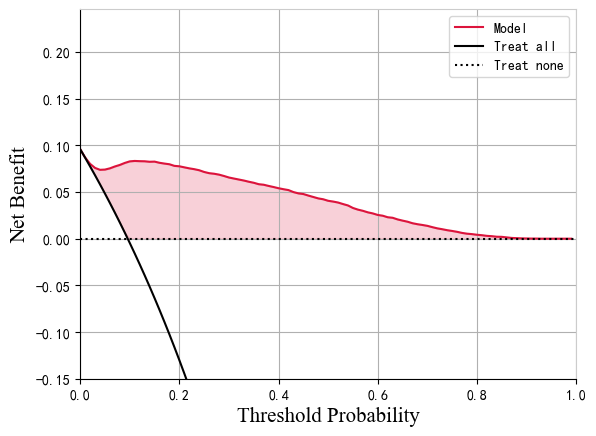

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model


def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all


def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all):
    #Plot
    ax.plot(thresh_group, net_benefit_model, color = 'crimson', label = 'Model')
    ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
    ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')

    #Fill
    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    ax.fill_between(thresh_group, y1, y2, color = 'crimson', alpha = 0.2)

    #Figure Configuration
    ax.set_xlim(0,1)
    ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
    ax.set_xlabel(
        xlabel = 'Threshold Probability', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.set_ylabel(
        ylabel = 'Net Benefit', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.grid('major')
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc = 'upper right')

    return ax


if __name__ == '__main__':
    y_pred_score = model.predict_proba(X_train)[:,1]
    y_label = y_train

    thresh_group = np.arange(0,1,0.01)
    net_benefit_model = calculate_net_benefit_model(thresh_group, y_pred_score, y_label)
    net_benefit_all = calculate_net_benefit_all(thresh_group, y_label)
    fig, ax = plt.subplots()
    ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all)
    plt.show()


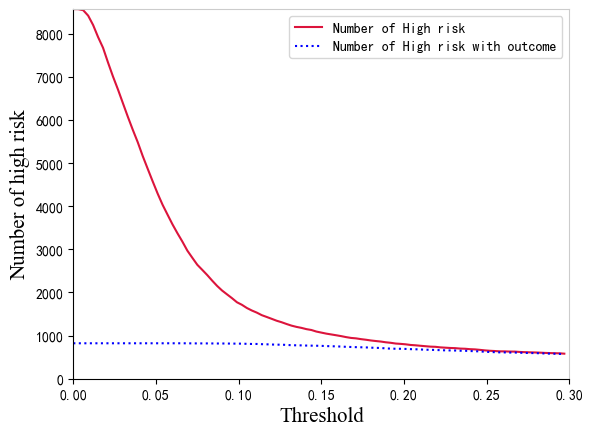

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def calculate_tp(thresh_group, y_pred_score, y_label):
    tp_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        tp_model = np.append(tp_model, tp)
    return tp_model


def calculate_p(thresh_group,y_pred_score, y_label):
    p_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        p_model = np.append(p_model, tp+fp)
    return p_model


def plot_DCA(ax, thresh_group, tp_model,p_model):
    #Plot
    ax.plot(thresh_group, p_model, color = 'crimson', label = 'Number of High risk')
    ax.plot(thresh_group, tp_model, color = 'blue',linestyle=':',label = 'Number of High risk with outcome')


    #Figure Configuration
    ax.set_xlim(0,0.3)
    ax.set_ylim(0, p_model.max())#adjustify the y axis limitation
    ax.set_xlabel(
        xlabel = 'Threshold', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.set_ylabel(
        ylabel = 'Number of high risk', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )

    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc = 'upper right')

    return ax


if __name__ == '__main__':
    y_pred_score = model.predict_proba(X_train)[:,1]
    y_label = y_train

    thresh_group = np.arange(0,0.3,0.003)
    tp_model = calculate_tp(thresh_group, y_pred_score, y_label)
    p_model = calculate_p(thresh_group, y_pred_score,y_label)
    fig, ax = plt.subplots()
    ax = plot_DCA(ax, thresh_group, tp_model, p_model)
    plt.show()


In [70]:
print(p_model)

8565.0
